# Learning Multi-Experiment Networks from High-Dimensional Point Process Data -- the Joint Estimation Procedure

## Generate Spike Train Data

### Generate connectivity matrix

As preparation, generate both the connectivity matrix (3-dimensional (M,p,p) array) and the background rate (2-dimensional (M,p) array). Please refer to functions save file: **genSetting.py**

In [1]:
import numpy as np
from neuronetlearn.genSetting import genCircleStarThreeNetworks
print_max  = lambda x : np.round( np.max( abs(np.real(x) ) ) , 2)

U, Beta= genCircleStarThreeNetworks(m=10,star_coef = -0.3, circle_coef = 0.3, U_coef=0.4)
M = U.shape[0]
'max eigen value of Connectivity Matrix:', [print_max( Beta[m]) for m in range(M)]

('max eigen value of Connectivity Matrix:', [0.3, 0.3, 0.3])

### Visualize true network structures

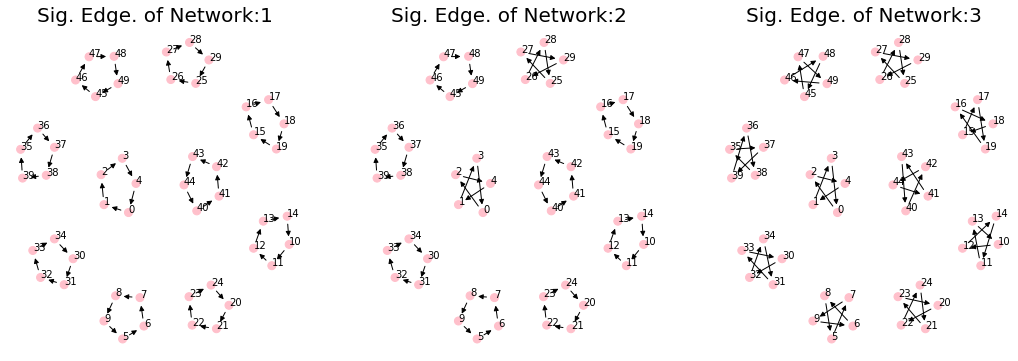

In [4]:
from igraph import *
import matplotlib.pyplot as plt 
from neuronetlearn.util import plot_graph
layout = plot_graph( Beta  )

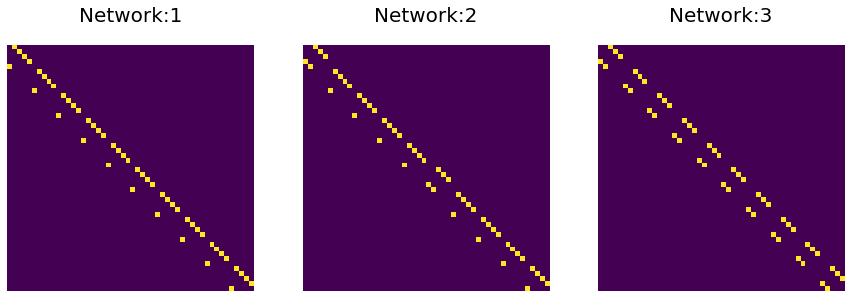

In [5]:
# instead of illustrating in graph, we can also illustrate the connectivity matrix 
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(Beta[m]!=0)
    axs[m].set_title('Network:'+ str(m+1) ,fontsize=20)

### Generate spike train data 

Spike train data is a type of point process data that is often referred in neuroscience. It records the spiking activity of neurons. Here we generate spike train data from a network of multiple neurons/point processes. In particular, Given the connectivity matrix and the background intensity rate as inputs, we generate spike train data from p processes under M experiment. The function **simu_net** is saved in **simu_net.py**

In [6]:
from neuronetlearn.simu_net import simu_net
T = [1000,1000,1000] 
rho, rate, lag = 2, 1, 1
M = Beta.shape[0]
p = Beta.shape[1]

np.random.seed(123)
DATA = simu_net( T, # length of each experiment, array of length M
                M, # no. experiments
                p, # no. processes
                Beta, U, # connectivity matrix and the background intensity rate
                rho , rate, lag # parameter used for transition kernel 
               )
Spike = DATA['Spike'] # output Spike, the spike train data, is a dictionary of length M with its value a p x p matrix
Phi = DATA['Phi'] # output Phi, the transition matrix, is a dictionary of length M with its value a p x p matrix

## Joint Estimation of Multi-Experiment Networks 

The key function, **net_est**, for multi-experiment network estimation are saved in **net_est.py**. The function repeatedly calls the general lasso solver (see function **spg_genlasso**). 

**net_est** has options of inputs of similarity matrix, **W**, and the transition matrix, **X**. **net_est** outputs the estimated connectivity matrix and background intensity. If **W** is None, the default is to get empirical cross-correlation based similarity matrix (by calling function **getW**). If **X** is None, the default is to calcualte the transition matrix using function **getX**. 

In [7]:
from neuronetlearn.net_est_auto import *

### Joint estimation using informative similarity weights (default) and auto-selected tuning parameters

By its default option, **net_est** only needs input of (multi-experiment) spike train/point process data. It jointly estimate networks under all experiments. 

The similarity matrix is internally calculated based on cross-correlations. The tuning parameters are auto-selected based on eBIC criteria. 

In [8]:
EST_ALL = net_est( Y=Spike,# outcome, dict, each  T x p array
                 # lams = lams
                #  X = None ,  # optional, design matrix , dict, if not given, generated with exponetial decay
                #  method = 'joint',#optional, default 'joint', joint est with informative weights
                #  W = None ,  # optional, weight matrix, if not given, generate empirical informative weights
                #  lams = None # optional, if not specified, auto select based on eBIC
                #  beta_init ,   # optional, initial coef values, default 0s
                #  eps, # optional: error of smoothing approxiamtion, default, 1e-4
                # max_iter, #optional: maximum iterations , default 1e4
                # tol , # optional: tolerance level of convergence, default, 1e-5
                # msg # optional: print convergence iterations, default, False  , 
            )

BETA_EST = EST_ALL['BETA_EST']
U_EST = EST_ALL['U_EST']
lam_opt = EST_ALL['lam_opt']

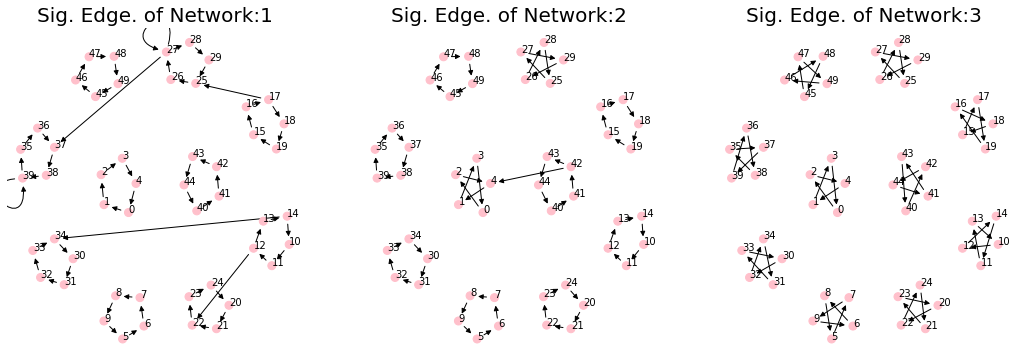

In [9]:
plot_graph( BETA_EST  , layout = layout  )

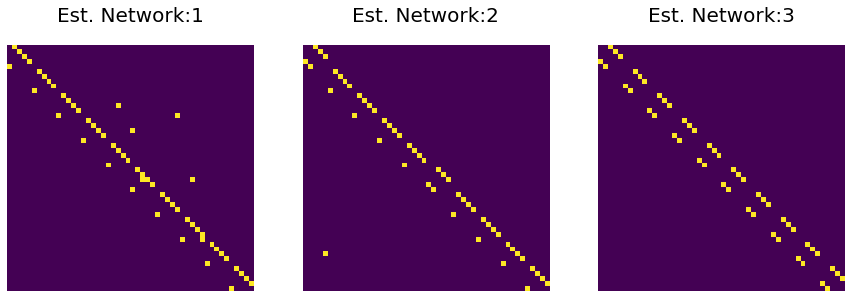

In [17]:
# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)


## Advanced Use

### Specify tuning parameters

**net_est** has option to specify tuning parameters for the joint estimation procedure. In this case, we take the optimal-selected tuning paramters from the last run, thus it gives the same results as before.

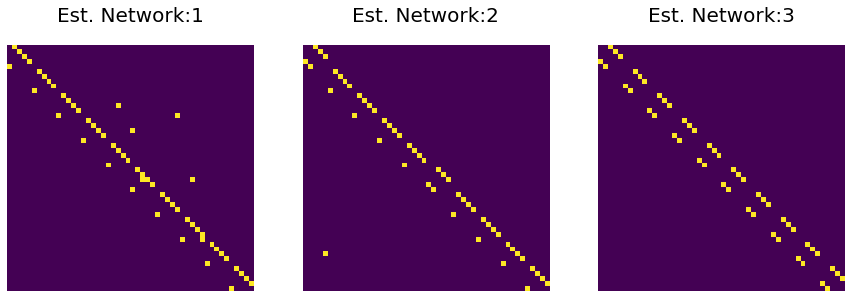

In [18]:
EST = net_est( Y=Spike, 
              lams = np.array( lam_opt ).reshape( (1,2) )  )

BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)

### Separate estimation 

By giving **method = 'separate'**, **net_est** also allows separate estimation -- that is estimating each network using its own data. 

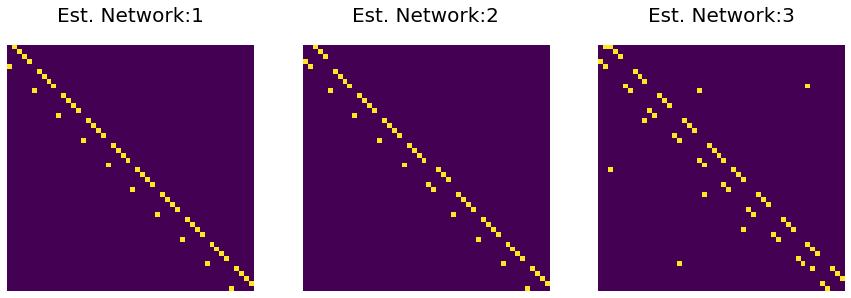

In [19]:
EST = net_est( Y=Spike,  method = 'separate' )

BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)

### Allow single experiment data as input

**net_est** is also compatible with estimation using single experiment data. It is automatically determined by checking the length of the data input. 

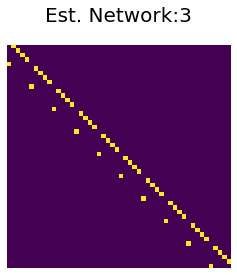

In [21]:
EST = net_est( Y={0:Spike[0]} )

BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

plt.matshow(BETA_EST[0] !=0)
plt.axis('off')
plt.title('Est. Network:'+ str(m+1) ,fontsize=20)
plt.show()

### Joint Estimation using uniform weights  

**net_est** also allows joint estimation using uniform weights --- that is, treating the network structure from all experiments equally similar. This procedure is done by specifying **method =='uniform'**.

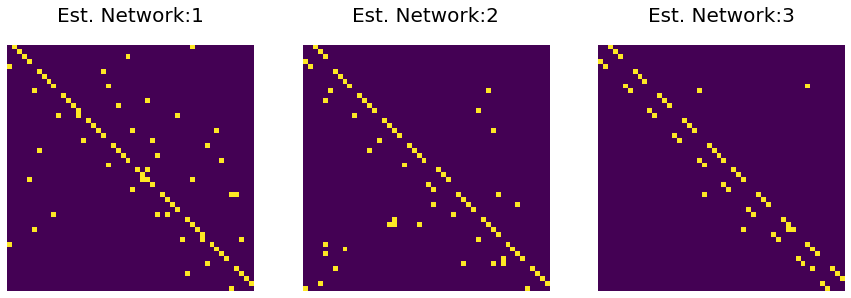

In [22]:
EST = net_est( Y=Spike, method = 'uniform'    )

BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)

### Customized similarity weights 

When external knowledge is available to decide the network similarity, user can incooperate such information in the esitmation by specifying the similarity matrix $W$. 

**net_est** allows to take in user-specified $W$ in the joint estimation procedure. For example, when all networks are considered equally similar, we can create $W$ as follows. 

In [23]:
# normalize W 
W = normalizeW (  np.ones( (M,M ) ) )

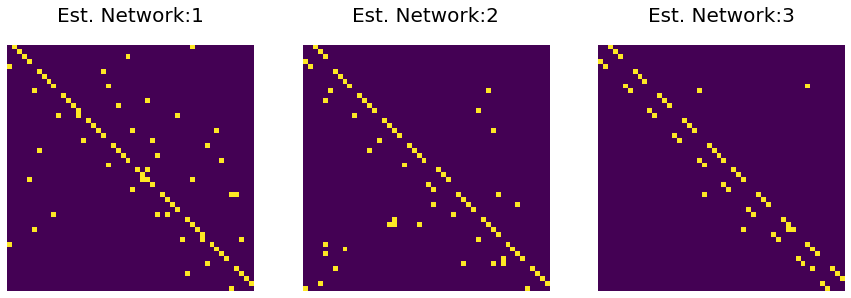

In [24]:
EST = net_est( Y=Spike, W = W  )

BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)

### Custimozed design matrix with user-specificed transition kernel

The default transition kernel is $2\exp( -t)$. **getX** function allows user to specific transition kernel as $ \rho \exp( -r(t-lag)_+ )$, where $\rho$ controls the scale of the transition kernel, $r$ controls the decay rate, $lag$ controls the time lag. With these parameters specified, the function takes in the input data and then creates the integrated process/design matrix based on the specified transition kernel. 

**net_est** has option to take in such customized design matrix in the joint estimation procedure. 

In [28]:
X = getX( Y= Spike ,  # spike train/point process data 
         rho=2, # scale 
         rate= 1,  # decay rate
         lag= 1 # time lag
        ) 

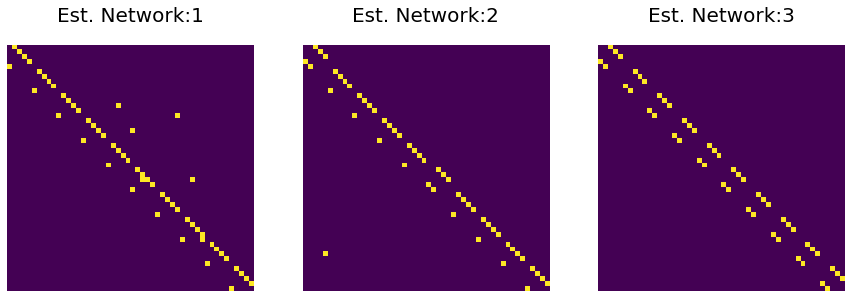

In [29]:
EST = net_est( Y=Spike, # outcome, dict, each  T x p array
               X=X, # design matrix , dict, optional, if not given, generate in the loop
               method = 'joint', # default method = 'joint', joint estimation with informative weights
             )


BETA_EST = EST['BETA_EST']
U_EST = EST['U_EST']

# plot estimated connectivity matrix
fig, axs = plt.subplots(1, 3,figsize=(15,45))
for m in range(M):
    axs[m].axis('off')
    axs[m].matshow(BETA_EST[m] !=0)
    axs[m].set_title('Est. Network:'+ str(m+1) ,fontsize=20)